In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
import util

In [4]:
ds = cifar10.CIFAR10()
# ds = mnist.MNIST()
model = cifar10.BigNetwork

Files already downloaded and verified
Files already downloaded and verified


In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [28]:

ds_small = cifar10.CIFAR10(bs_train=10, bs_test=100)

Files already downloaded and verified
Files already downloaded and verified


In [44]:
def calc_grad_noise(net):
    opt = torch.optim.Adam(net.parameters(), lr=0.)

    gs = []
    for i in range(50):
        x, y = next(iter(ds_small.dl_train))
        yp = net(x)
        loss = ds.loss_fn(yp, y)

        opt.zero_grad()
        loss.backward()
        
        g = torch.cat([pi.grad.flatten() for pi in net.parameters()])
        gs.append(g)
    gs = torch.stack(gs)
    dots = (gs[:, None]*gs[None, :]).sum(dim=-1)
    
    return (dots*(1-torch.eye(len(dots)))).mean().item()
    
    
def train_adam(net, accu, lr=1e-2):
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    for epoch_idx in tqdm(range(5)):
        loop = tqdm(ds.dl_train)
        for x, y in loop:
            grad_noise = calc_grad_noise(net)
            # print(grad_noise)
            
            yp = net(x)
            loss = ds.loss_fn(yp, y)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            data = dict(loss_batch=loss.item(), grad_noise=grad_noise)
            accu.append(**data)
            loop.set_postfix(data)

In [45]:
net = model()
accu = util.Accumulator()
train_adam(net, accu)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

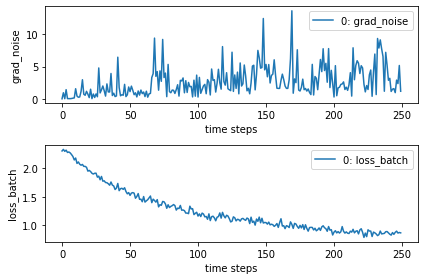

In [46]:
util.plot_accumulators([accu])

In [43]:
accu